# Approach 1a: Basic frame differencing
For this most basic approach, we compare each motion image $M$ to the closest lapse image $L$ and take the
1. mean absolute pixel-wise difference $ \frac{1}{xy} \sum_{x,y} | M_{x,y} - L_{x,y} | $
2. mean squared pixel-wise difference $ \frac{1}{xy} \sum_{x,y} (M_{x,y} - L_{x,y})^2 $
M and L are both grayscale.

**Reasoning:** We assume that anomalous images highly differ from the closest lapse image in a significant amount of pixels while normal images only have low pixel differences.

### Suspected problems
- **Noise** (we scale the images down for performance reasons which also reduces noise a bit)
- **Small object movements** that are not of interest (such as leaves, dust particles, etc.)
- Very sensitive to **camera movement** (which seems to happen a lot in the dataset)
- Since we eliminate the **color information**, a deer might look very much like a forest.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from tqdm import tqdm

from py.PlotUtils import plot_roc_curve, get_percentiles
from py.Dataset import Dataset
from py.Session import MotionImage
from py.ImageUtils import display_images, is_daytime
from py.Labels import LABELS
from py.ImageClassifier import AbstractImageClassifier

DIR = './ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

Found 2 sessions
Session 'Beaver_01' at folder: ./ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


## Experiment 1: Basic classifier
The proposed classifier computes the following features
- mean of absolute pixel-wise difference _absmean_
- variance of absolute pixel-wise difference _absvar_
- mean of squared pixel-wise difference _sqmean_
- var of squared pixel-wise difference _sqvar_

In [2]:
def normalize(comp_arr, motion_arr):
    # normalize comp_arr and transform motion_arr identically
    mean, std = np.mean(comp_arr), np.std(comp_arr)
    motion_arr = (motion_arr - mean) / std
    comp_arr = (comp_arr - mean) / std
    return comp_arr, motion_arr

def normalize_img(img):
    return (img - np.mean(img)) / np.std(img)

class FrameDiffClassifier(AbstractImageClassifier):
    def evaluate(self, motion_img: MotionImage, display=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(gray=False)
        comp_arr = comp_img.read(gray=False)
        motion_daytime = is_daytime(motion_arr)

        # don't compare daytime with nighttime images
        if motion_daytime != is_daytime(comp_arr):
            # choose the other closest lapse image
            comp_img = after_img if rel <= 0.5 else before_img
            comp_arr = comp_img.read(gray=False)
            assert motion_daytime == is_daytime(comp_arr)
            # if this assertion fails, a motion image was captured at daytime between two nighttime lapse images or the other way around

        # convert to gray
        motion_arr = rgb2gray(motion_arr)
        comp_arr = rgb2gray(comp_arr)

        # comp_arr, motion_arr = normalize(comp_arr, motion_arr)
        comp_arr, motion_arr = normalize_img(comp_arr), normalize_img(motion_arr)

        absdiff = abs(motion_arr - comp_arr)
        sqdiff = (motion_arr - comp_arr) ** 2
        absmean = np.average(absdiff)
        absstd = np.std(absdiff)
        sqmean = np.average(sqdiff)
        sqstd = np.std(sqdiff)

        if display:
            display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, std = {absstd}", f"sq mean = {sqmean}, std = {sqstd}"], cmap="gray")

        return absmean, absstd, sqmean, sqstd

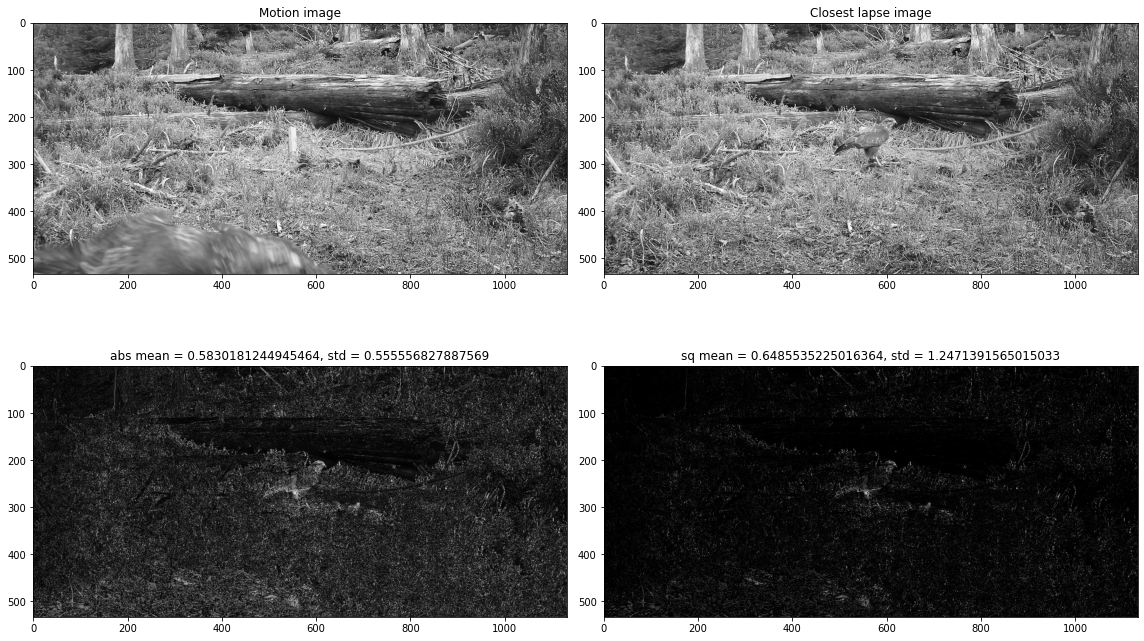

(0.5830181244945464, 0.555556827887569, 0.6485535225016364, 1.2471391565015033)

In [3]:
img = session.get_random_motion_image(day_only=True)
classifier = FrameDiffClassifier()
classifier.evaluate(img, display=True)

The anomalous object is usually clearly visible in the difference image but there are still a lot of unwanted artefacts around it (possibly because of small object movement and noise).

In [4]:
def generate_test_scores(classifier):
    normal_scores = []
    anomalous_scores = []

    for img in tqdm(list(session.generate_motion_images())):
        img_nr = int(img.filename[10:-4])
        if img_nr > LABELS[session.name]["max"]:
            continue
        score = classifier.evaluate(img)
        if img_nr in LABELS[session.name]["normal"]:
            normal_scores.append(score)
        else:
            anomalous_scores.append(score)
    return normal_scores, anomalous_scores


classifier = FrameDiffClassifier()
normal_scores, anomalous_scores = generate_test_scores(classifier)

100%|██████████| 695/695 [00:59<00:00, 11.64it/s]


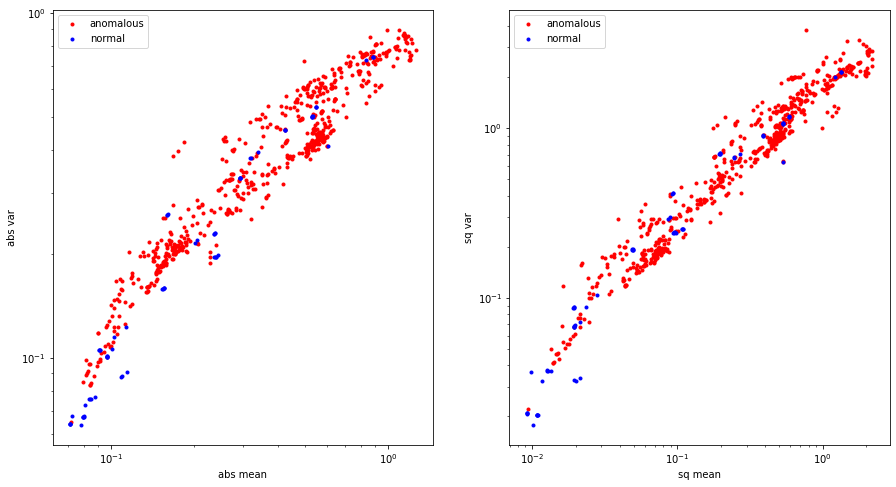

In [5]:
def plot(i1, i2, normal_scores, anomalous_scores, scale="log"):
    titles = ["abs mean", "abs var", "sq mean", "sq var"]
    plt.scatter([ar[i1] for ar in anomalous_scores], [ar[i2] for ar in anomalous_scores], color="red", label="anomalous", marker=".")
    plt.scatter([ar[i1] for ar in normal_scores], [ar[i2] for ar in normal_scores], color="blue", label="normal", marker=".")
    plt.xlabel(titles[i1])
    plt.ylabel(titles[i2])
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()
    
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot(0, 1, normal_scores, anomalous_scores)
plt.subplot(1, 2, 2)
plot(2, 3, normal_scores, anomalous_scores)
plt.show()

In [6]:
y_anom = np.array(anomalous_scores)
assert y_anom.shape[1] == 4

y_norm = np.array(normal_scores)
assert y_norm.shape[1] == 4

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(695, 4)
(695,)


0.9 percentile : TPR = 0.9227, FPR = 0.5811 <-> TNR = 0.4189 @ thresh 0.11559366582259728
0.95 percentile : TPR = 0.9533, FPR = 0.6486 <-> TNR = 0.3514 @ thresh 0.10078405586237728
0.98 percentile : TPR = 0.9807, FPR = 0.7838 <-> TNR = 0.2162 @ thresh 0.08912281297293448
0.99 percentile : TPR = 0.9968, FPR = 0.8378 <-> TNR = 0.1622 @ thresh 0.08113976314506045
absmean auc=0.7307960134047091
0.9 percentile : TPR = 0.9195, FPR = 0.5135 <-> TNR = 0.4865 @ thresh 0.1597904067052574
0.95 percentile : TPR = 0.9501, FPR = 0.5811 <-> TNR = 0.4189 @ thresh 0.12430776868553675
0.98 percentile : TPR = 0.9871, FPR = 0.7432 <-> TNR = 0.2568 @ thresh 0.09134296262895039
0.99 percentile : TPR = 0.9903, FPR = 0.7568 <-> TNR = 0.2432 @ thresh 0.08903542053416316
absvar auc=0.7414370892631762
0.9 percentile : TPR = 0.9452, FPR = 0.5811 <-> TNR = 0.4189 @ thresh 0.02817008267638741
0.95 percentile : TPR = 0.9581, FPR = 0.5946 <-> TNR = 0.4054 @ thresh 0.024229766266360083
0.98 percentile : TPR = 0.9968, 

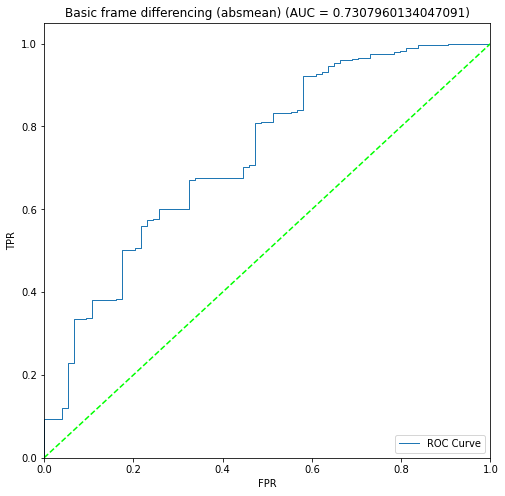

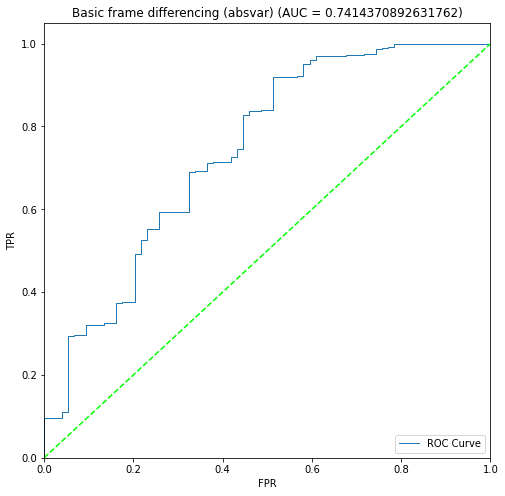

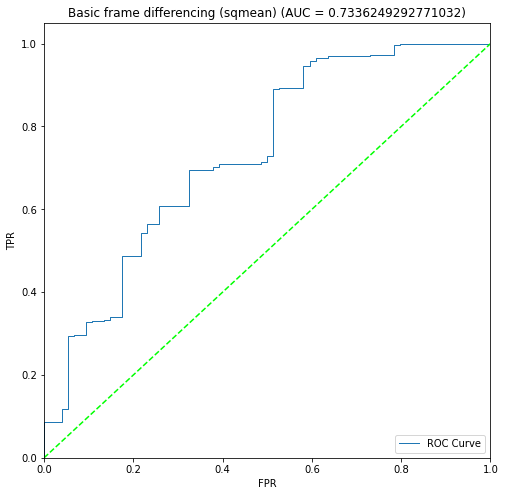

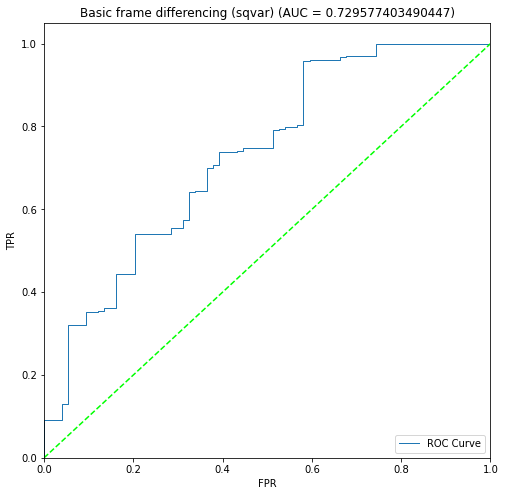

In [7]:
vals = ["absmean", "absvar", "sqmean", "sqvar"]
for i in range(4):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Basic frame differencing ({vals[i]})", savefile=f"plots/approach1a/roc_curves/{session.name}_{vals[i]}", show=False)
    get_percentiles(fpr, tpr, thresholds)
    print(f"{vals[i]} auc={auc_score}")

## Experiment 2: Add a Gaussian filter

In [8]:
from py.ImageClassifier import AbstractImageClassifier
from scipy import ndimage

class GaussianFrameDiffClassifier(AbstractImageClassifier):
    def __init__(self, sigma: int):
        self.sigma = sigma
    
    def evaluate(self, motion_img: MotionImage, display=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(gray=False)
        comp_arr = comp_img.read(gray=False)
        motion_daytime = is_daytime(motion_arr)

        # don't compare daytime with nighttime images
        if motion_daytime != is_daytime(comp_arr):
            # choose the other closest lapse image
            comp_img = after_img if rel <= 0.5 else before_img
            comp_arr = comp_img.read(gray=False)
            assert motion_daytime == is_daytime(comp_arr)
            # if this assertion fails, a motion image was captured at daytime between two nighttime lapse images or the other way around

        # convert to gray
        motion_arr = rgb2gray(motion_arr)
        comp_arr = rgb2gray(comp_arr)

        comp_arr, motion_arr = normalize_img(comp_arr), normalize_img(motion_arr)

        motion_arrg = ndimage.gaussian_filter(motion_arr, sigma=self.sigma)
        comp_arrg = ndimage.gaussian_filter(comp_arr, sigma=self.sigma)

        absdiff = abs(motion_arrg - comp_arrg)
        sqdiff = (motion_arrg - comp_arrg) ** 2
        absmean = np.average(absdiff)
        absvar = np.var(absdiff)
        sqmean = np.average(sqdiff)
        sqvar = np.var(sqdiff)

        if display:
            display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, var = {absvar}", f"sq mean = {sqmean}, var = {sqvar}"], cmap="gray")

        return absmean, absvar, sqmean, sqvar

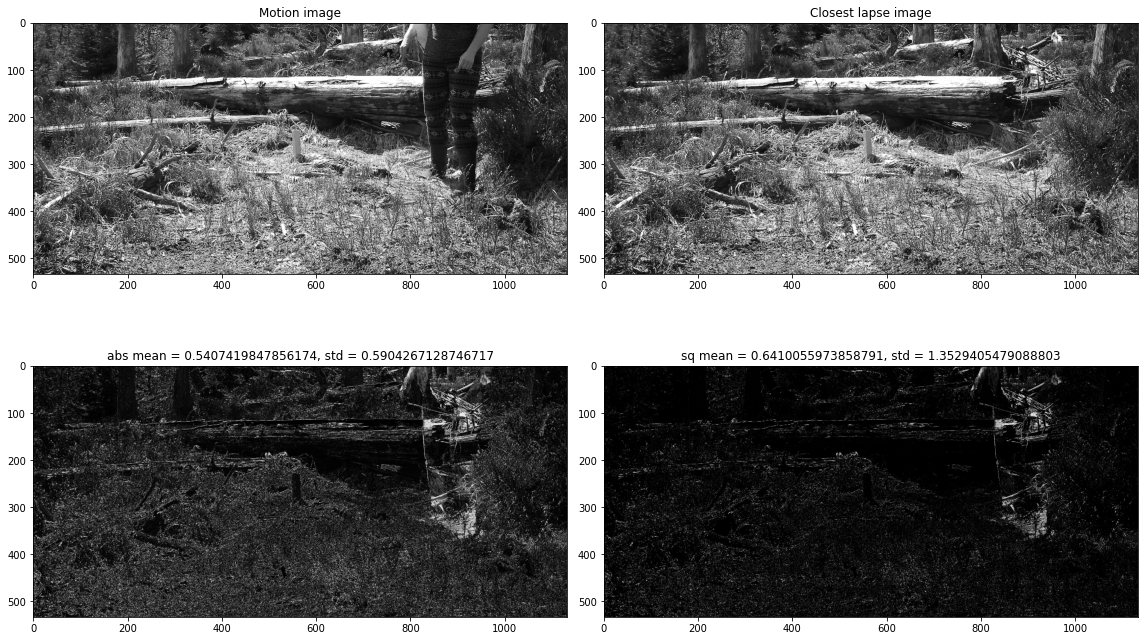

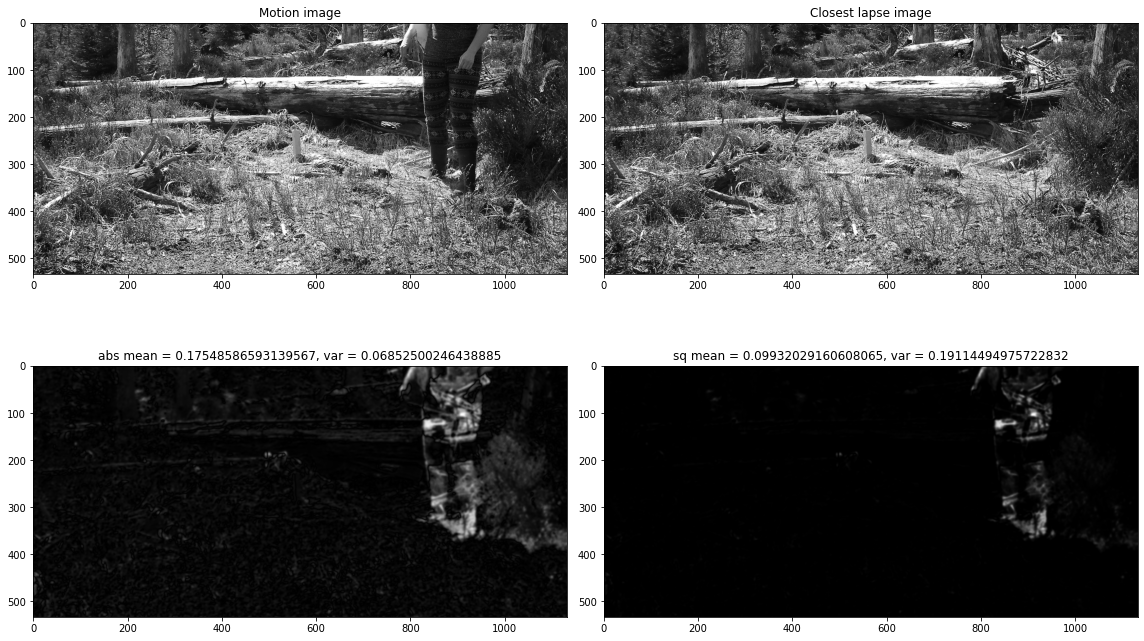

(0.17548586593139567,
 0.06852500246438885,
 0.09932029160608065,
 0.19114494975722832)

In [9]:
img = session.get_random_motion_image(day_only=True)
classifier = FrameDiffClassifier()
classifier.evaluate(img, display=True)
classifier2 = GaussianFrameDiffClassifier(sigma=2)
classifier2.evaluate(img, display=True)

In [10]:
classifier = GaussianFrameDiffClassifier(sigma=2)
normal_scores_g, anomalous_scores_g = generate_test_scores(classifier)

100%|██████████| 695/695 [01:25<00:00,  8.09it/s]


In [11]:
classifier = GaussianFrameDiffClassifier(sigma=4)
normal_scores_g2, anomalous_scores_g2 = generate_test_scores(classifier)

100%|██████████| 695/695 [01:33<00:00,  7.45it/s]


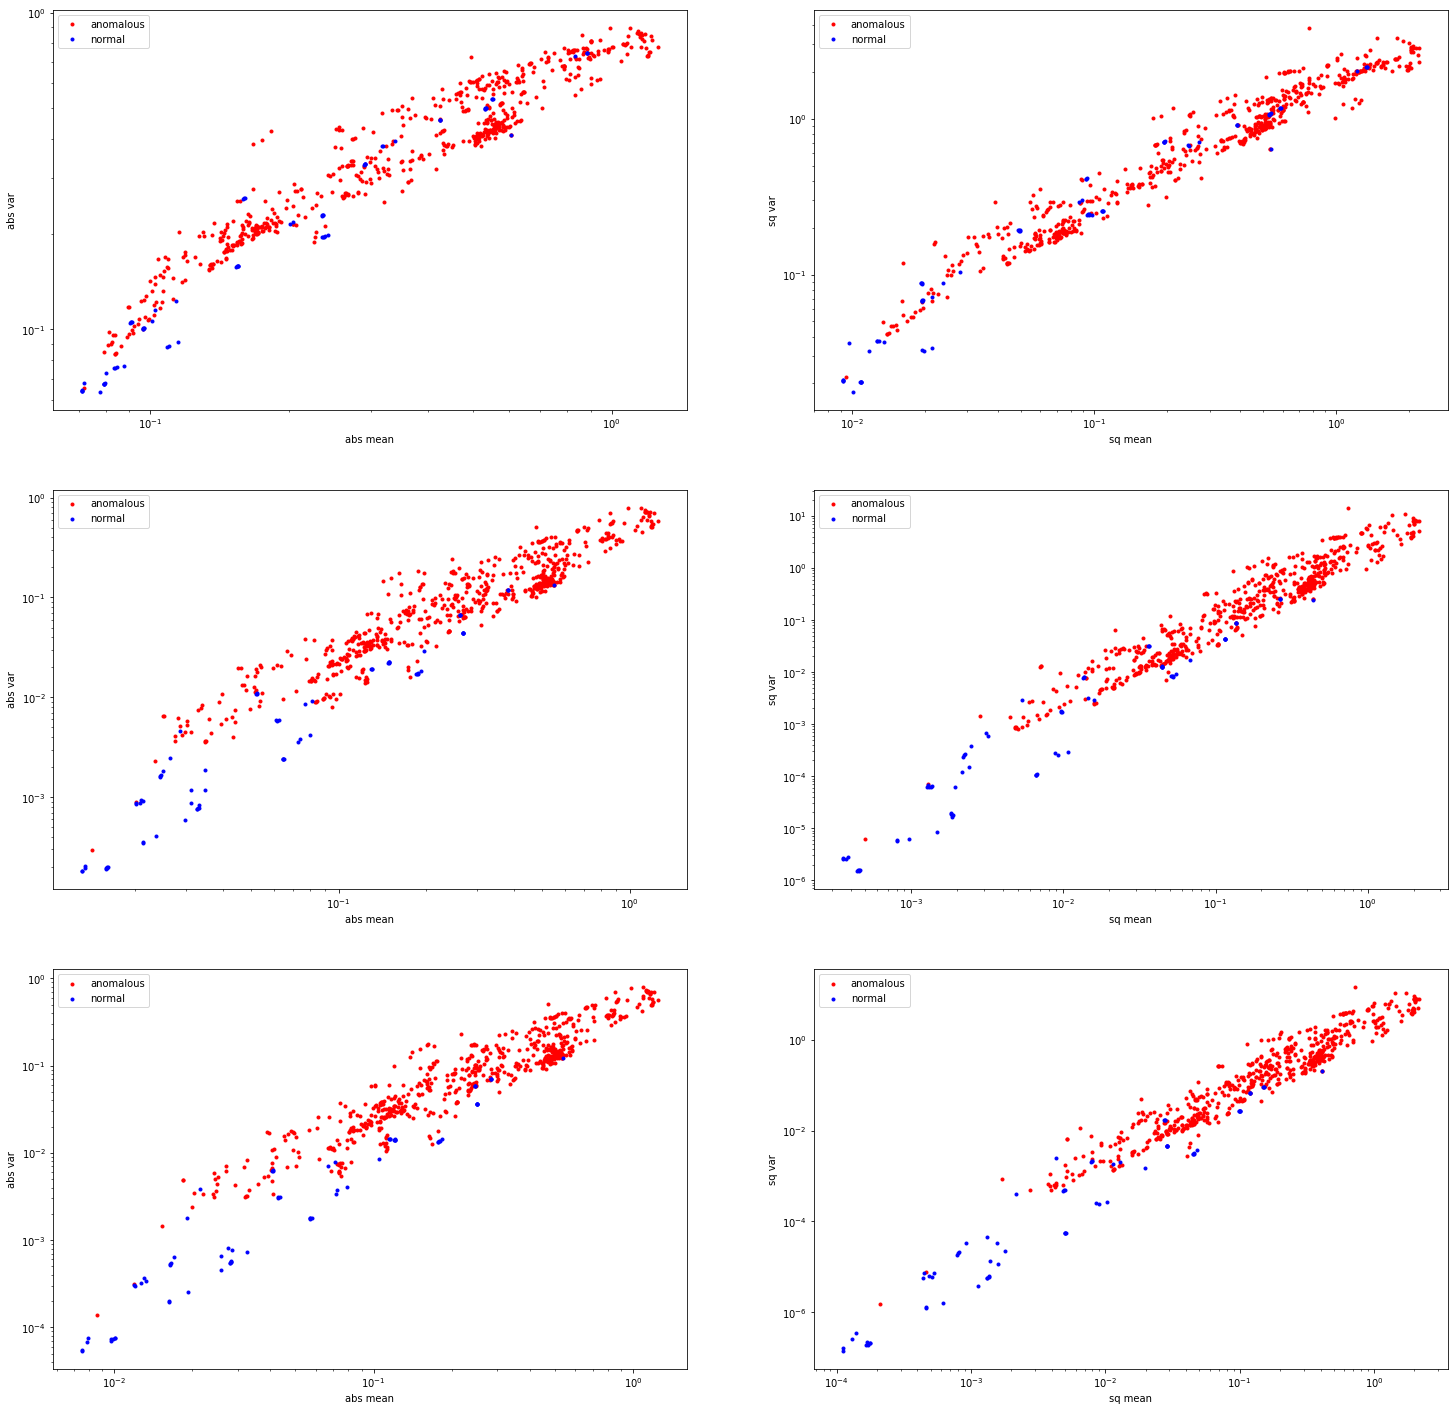

In [12]:
scale = "log"
plt.figure(figsize=(25, 25))
plt.subplot(3, 2, 1)
plot(0, 1, normal_scores, anomalous_scores, scale=scale)
plt.subplot(3, 2, 2)
plot(2, 3, normal_scores, anomalous_scores, scale=scale)
plt.subplot(3, 2, 3)
plot(0, 1, normal_scores_g, anomalous_scores_g, scale=scale)
plt.subplot(3, 2, 4)
plot(2, 3, normal_scores_g, anomalous_scores_g, scale=scale)
plt.subplot(3, 2, 5)
plot(0, 1, normal_scores_g2, anomalous_scores_g2, scale=scale)
plt.subplot(3, 2, 6)
plot(2, 3, normal_scores_g2, anomalous_scores_g2, scale=scale)
plt.show()

In [15]:
y_anom = np.array(anomalous_scores_g2)
assert y_anom.shape[1] == 4

y_norm = np.array(normal_scores_g2)
assert y_norm.shape[1] == 4

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(695, 4)
(695,)


absmean sigma=2 auc=0.8293946120033077
0.9 percentile : TPR = 0.9002, FPR = 0.3649 <-> TNR = 0.6351 @ thresh 0.07249433566897984
0.95 percentile : TPR = 0.9646, FPR = 0.5541 <-> TNR = 0.4459 @ thresh 0.03261906593919228
0.98 percentile : TPR = 0.9887, FPR = 0.6892 <-> TNR = 0.3108 @ thresh 0.021977000274880486
0.99 percentile : TPR = 0.9919, FPR = 0.7027 <-> TNR = 0.2973 @ thresh 0.01988756449288908
absvar sigma=2 auc=0.9067545806676243
0.9 percentile : TPR = 0.9211, FPR = 0.3378 <-> TNR = 0.6622 @ thresh 0.009052023616784883
0.95 percentile : TPR = 0.9775, FPR = 0.4189 <-> TNR = 0.5811 @ thresh 0.00428247310101172
0.98 percentile : TPR = 0.9871, FPR = 0.4595 <-> TNR = 0.5405 @ thresh 0.00338826930319687
0.99 percentile : TPR = 0.9936, FPR = 0.4730 <-> TNR = 0.5270 @ thresh 0.0031191044471881387
sqmean sigma=2 auc=0.8777037907472691
0.9 percentile : TPR = 0.9179, FPR = 0.3514 <-> TNR = 0.6486 @ thresh 0.013134956441145457
0.95 percentile : TPR = 0.9517, FPR = 0.3919 <-> TNR = 0.6081 @ 

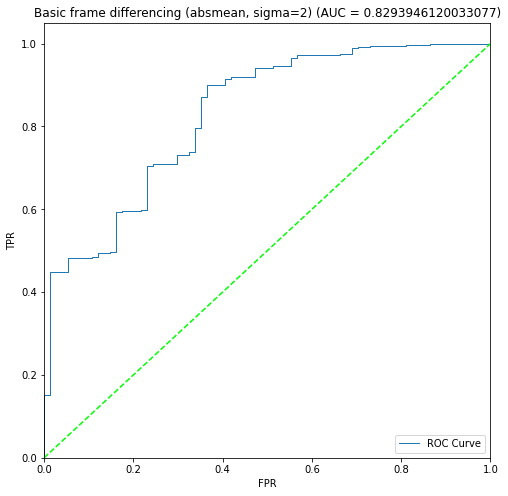

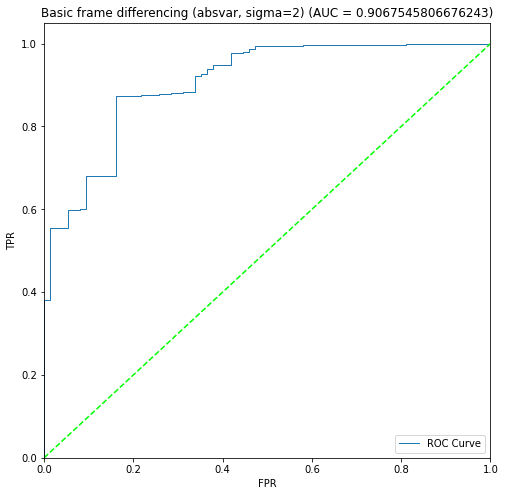

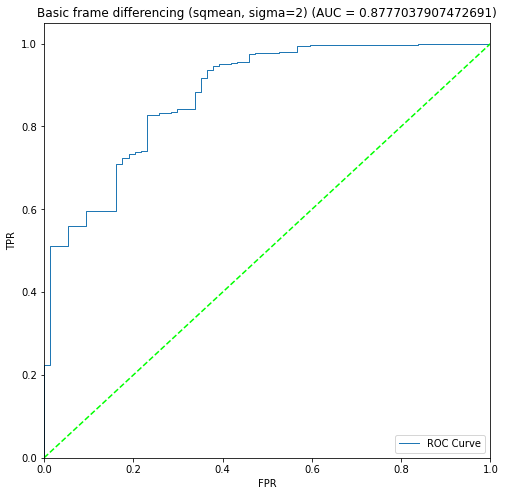

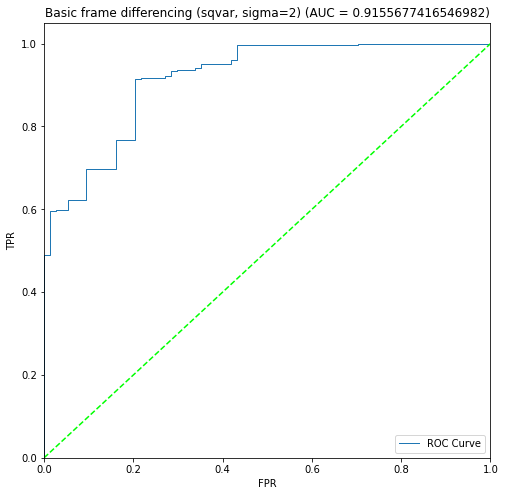

In [16]:
sigma = 2
vals = ["absmean", "absvar", "sqmean", "sqvar"]
for i in range(4):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Basic frame differencing ({vals[i]}, sigma=2)", savefile=f"plots/approach1a/roc_curves/{session.name}_{vals[i]}_sigma{sigma}", show=False)
    print(f"{vals[i]} sigma={sigma} auc={auc_score}")
    get_percentiles(fpr, tpr, thresholds)